In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve

In [336]:
df = pd.read_csv('../../datasets/famcs_students.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cource           127 non-null    int64  
 1   group            127 non-null    int64  
 2   stream           127 non-null    object 
 3   sex              127 non-null    object 
 4   age              127 non-null    float64
 5   ss               127 non-null    object 
 6   interest         127 non-null    object 
 7   os               127 non-null    object 
 8   weekend_study    127 non-null    object 
 9   bad_sleep        127 non-null    object 
 10  glasses          127 non-null    object 
 11  work_experience  127 non-null    object 
 12  ai               127 non-null    object 
 13  height           127 non-null    float64
 14  anime            127 non-null    object 
 15  social           127 non-null    object 
 16  sport            127 non-null    object 
 17  miss            

In [337]:
N = 25
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']
target_col = binary_cols[N % 8]
print(target_col)

interest


In [ ]:

df['work_experience'] = (df['work_experience'] != 'Не работаю').astype(int)

feature_cols = ['stream', 'os', 'work_experience', 'anime', 'score', 'miss', 'glasses']
#feature_cols = ['literature', 'foot_size']
#feature_cols = [col for col in df.columns if col != target_col]
X = df[feature_cols]
y = df[target_col]


In [339]:
def preprocess_data(X):
    X_processed = X.copy()
    categorical_cols = X_processed.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        X_processed = pd.get_dummies(X_processed, columns=categorical_cols, drop_first=True)
    
    return X_processed

In [340]:

X_processed = preprocess_data(X)
X_processed.head()

,work_experience,score,miss,stream_Прикладная информатика,stream_Прикладная математика,os_MacOS,os_Windows,anime_Нет,glasses_Нет
0,1,9.2,3.0,True,False,True,False,True,True
1,1,8.8,5.0,True,False,True,False,True,True
2,1,8.8,10.0,True,False,True,False,True,True
3,1,8.8,3.0,True,False,True,False,True,True
4,0,9.0,1.0,True,False,False,True,True,True


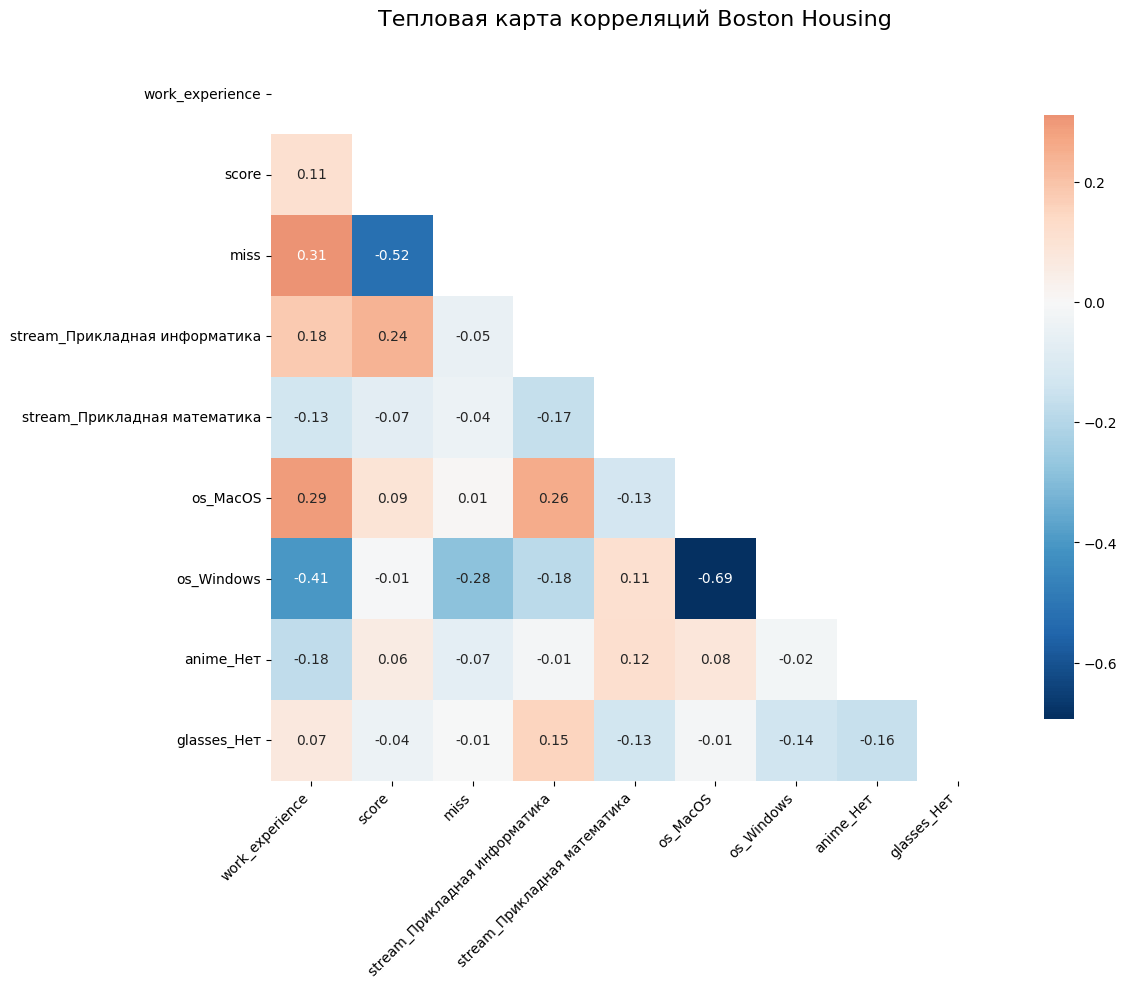

In [341]:
plt.figure(figsize=(12, 10))
corr_matrix = X_processed.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
heatmap = sns.heatmap(corr_matrix,
                      mask=mask,
                      annot=True,
                      cmap='RdBu_r',
                      center=0,
                      square=True,
                      fmt='.2f',
                      cbar_kws={'shrink': 0.8},
                      annot_kws={'size': 10})

plt.title('Тепловая карта корреляций Boston Housing', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [342]:
y.head(10)

0          Математика
1    Программирование
2    Программирование
3          Математика
4          Математика
5    Программирование
6    Программирование
7    Программирование
8          Математика
9    Программирование
Name: interest, dtype: object

In [343]:
y = y.map({'Математика':1, 'Программирование': 0})
y.head(10)

0    1
1    0
2    0
3    1
4    1
5    0
6    0
7    0
8    1
9    0
Name: interest, dtype: int64

In [344]:
X_temp, X_test, y_temp, y_test = train_test_split(X_processed, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)
print(X_train.shape, X_val.shape, X_test.shape)

(88, 9) (19, 9) (20, 9)


In [345]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 0. Trivial

In [346]:
class TrivialClassifier:
    def __init__(self):
        self.most_frequent_class = None
    
    def fit(self, X, y):
        self.most_frequent_class = y.mode()[0]
        return self
    
    def predict(self, X):
        return np.array([self.most_frequent_class] * len(X))
    
    def predict_proba(self, X):
        prob = np.zeros((len(X), 2))
        prob[:, self.most_frequent_class] = 1.0
        return prob

# 1. Наивный байесовский классификатор

In [347]:
class NaiveBayesClassifier:
    def __init__(self):
        self.class_priors = None
        self.means = None
        self.stds = None
        self.classes = None
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_priors = {}
        self.means = {}
        self.stds = {}
        
        for c in self.classes:
            X_c = X[y == c]
            self.class_priors[c] = len(X_c) / len(X)
            self.means[c] = X_c.mean(axis=0)
            self.stds[c] = X_c.std(axis=0) + 1e-6
        
        return self
    
    def _gaussian_pdf(self, x, mean, std):
        return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    
    def predict_proba(self, X):
        probabilities = []
        
        for i in range(len(X)):
            sample = X[i]
            class_probs = {}
            
            for c in self.classes:
                class_prob = np.log(self.class_priors[c])
                
                for j in range(len(sample)):
                    feature_prob = self._gaussian_pdf(sample[j], self.means[c][j], self.stds[c][j])
                    class_prob += np.log(feature_prob + 1e-6)
                
                class_probs[c] = class_prob
            
            max_prob = max(class_probs.values())
            exp_probs = {c: np.exp(prob - max_prob) for c, prob in class_probs.items()}
            sum_probs = sum(exp_probs.values())
            normalized_probs = {c: prob / sum_probs for c, prob in exp_probs.items()}
            
            probabilities.append([normalized_probs.get(0, 0), normalized_probs.get(1, 0)])
        
        return np.array(probabilities)
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

# 2. Метод k-ближайших соседей

In [348]:
class KNNClassifier:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y.values if hasattr(y, 'values') else y
        return self
    
    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def predict_proba(self, X):
        X = X
        probabilities = []
        
        for sample in X:
            distances = []
            
            for i, train_sample in enumerate(self.X_train):
                dist = self._euclidean_distance(sample, train_sample)
                distances.append((dist, self.y_train[i]))
            
            distances.sort(key=lambda x: x[0])
            neighbors = distances[:self.k]
            
            votes = {0: 0, 1: 0}
            for _, label in neighbors:
                votes[label] += 1
            
            prob_0 = votes[0] / self.k
            prob_1 = votes[1] / self.k
            probabilities.append([prob_0, prob_1])
        
        return np.array(probabilities)
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

# 3. Логистическая регрессия

In [357]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, n_iter=1000):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.weights = None
        self.bias = None
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        X = X
        y = y
        
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for _ in range(self.n_iter):
            linear_model = np.dot(X, self.weights) + self.bias
            predictions = self._sigmoid(linear_model)
            
            dw = (1 / n_samples) * np.dot(X.T, (predictions - y))
            db = (1 / n_samples) * np.sum(predictions - y)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
        
        return self
    
    def predict_proba(self, X):
        X = X.values if hasattr(X, 'values') else X
        linear_model = np.dot(X, self.weights) + self.bias
        probabilities = self._sigmoid(linear_model)
        return np.column_stack([1 - probabilities, probabilities])
    
    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= threshold).astype(int)

# 4. Оценка качества
Для каждой построенной модели, по отложенной тестовой выборке оцените качество моделей:

accuracy  
precision  
recall  
roc-auc  
постройте матрицу ошибок

In [350]:
def evaluate_model(model, X_test, y_test, name, threshold=0.5):
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)
    else:
        y_pred = model.predict(X_test)
        y_proba = None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    
    roc_auc = None
    if y_proba is not None:
        roc_auc = roc_auc_score(y_test, y_proba)
    
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"\n{name}:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    if roc_auc is not None:
        print(f"ROC-AUC: {roc_auc:.3f}")
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

In [351]:
results = {}


Trivial Classifier:
Accuracy: 0.700
Precision: 0.000
Recall: 0.000
ROC-AUC: 0.500


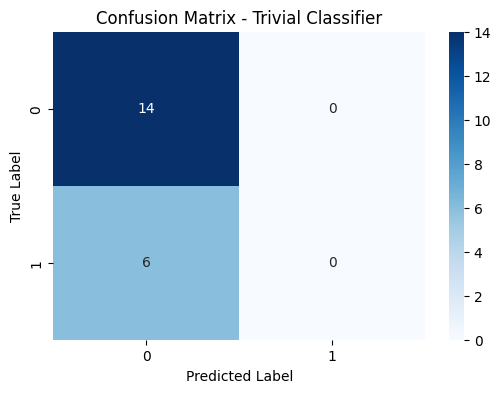

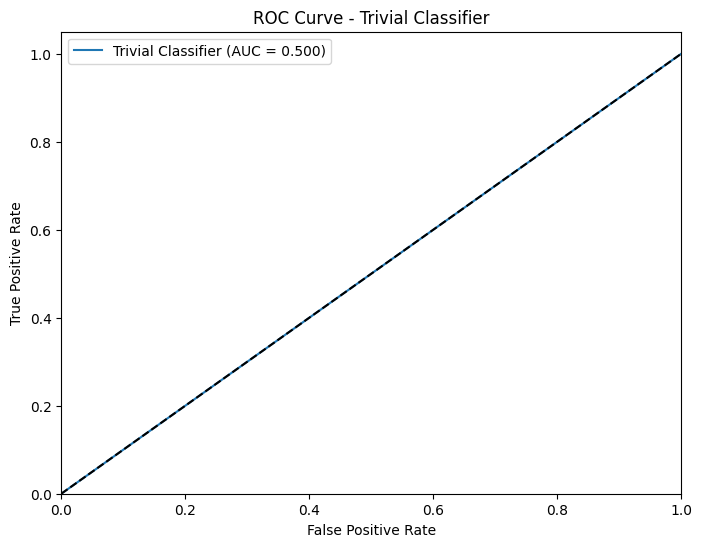

In [352]:
trivial_clf = TrivialClassifier()
trivial_clf.fit(X_train, y_train)
results['Trivial'] = evaluate_model(trivial_clf, X_test, y_test, "Trivial Classifier")


Naive Bayes:
Accuracy: 0.750
Precision: 0.667
Recall: 0.333
ROC-AUC: 0.643


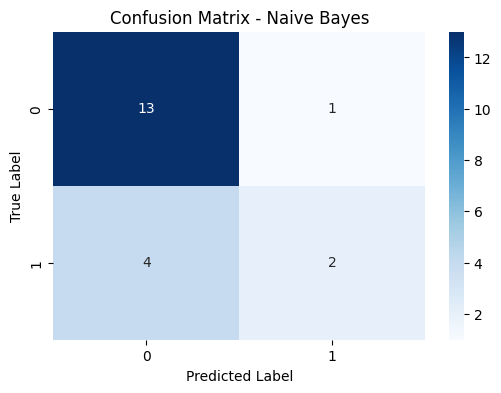

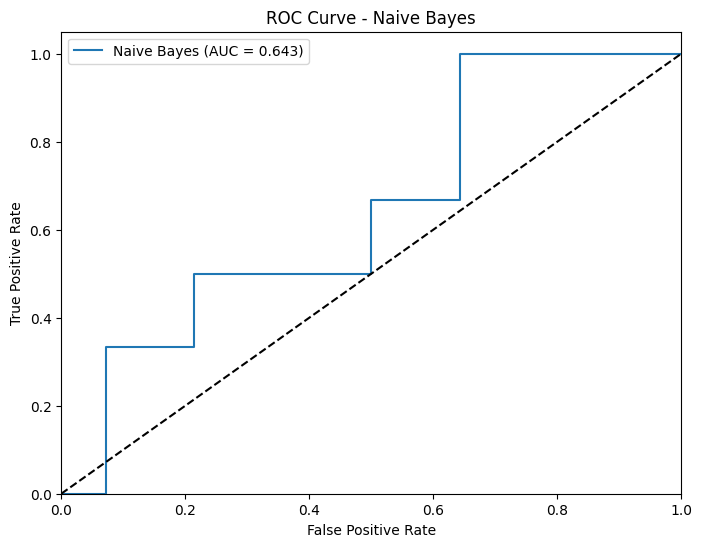

In [ ]:
nb_clf = NaiveBayesClassifier()
nb_clf.fit(X_train_scaled, y_train)
results['Naive Bayes'] = evaluate_model(nb_clf, X_test_scaled, y_test, "Naive Bayes")

k=1: F1-score = 0.167
k=3: F1-score = 0.000
k=5: F1-score = 0.000
k=7: F1-score = 0.000
k=9: F1-score = 0.000
k=11: F1-score = 0.000
k=15: F1-score = 0.000
k=21: F1-score = 0.000
Оптимальный k: 1

KNN (k=1):
Accuracy: 0.700
Precision: 0.500
Recall: 0.333
ROC-AUC: 0.595


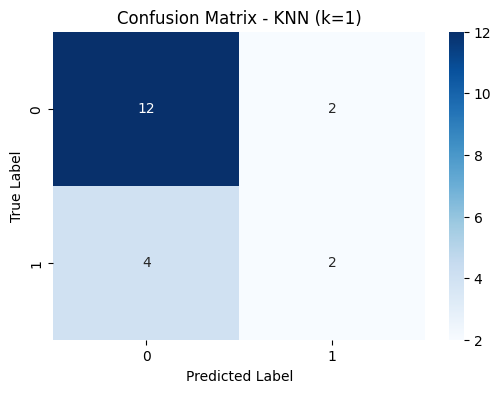

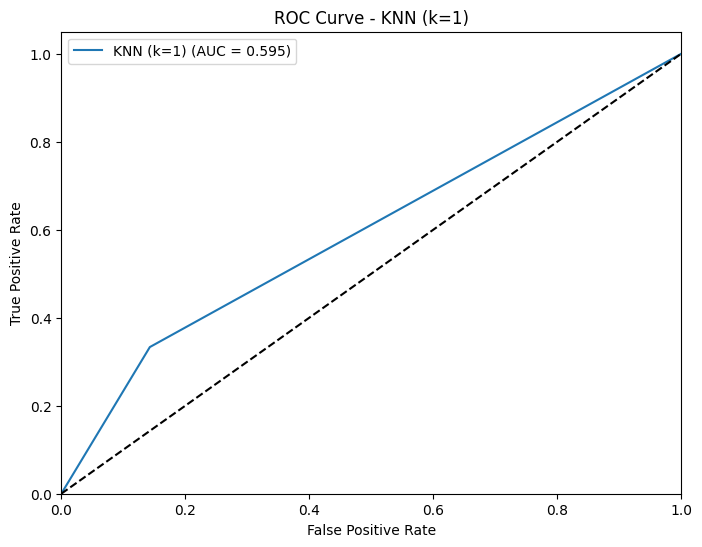

In [ ]:
best_k = 1
best_f1 = 0

for k in [1, 3, 5, 7, 9, 11, 15, 21]:
    knn_temp = KNNClassifier(k=k)
    knn_temp.fit(X_train_scaled, y_train)
    y_pred_val = knn_temp.predict(X_val_scaled)
    
    precision = precision_score(y_val, y_pred_val, zero_division=0)
    recall = recall_score(y_val, y_pred_val, zero_division=0)
    
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    
    print(f"k={k}: F1-score = {f1:.3f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_k = k

print(f"Оптимальный k: {best_k}")

knn_clf = KNNClassifier(k=best_k)
knn_clf.fit(X_train_scaled, y_train)
results['KNN'] = evaluate_model(knn_clf, X_test_scaled, y_test, f"KNN (k={best_k})")

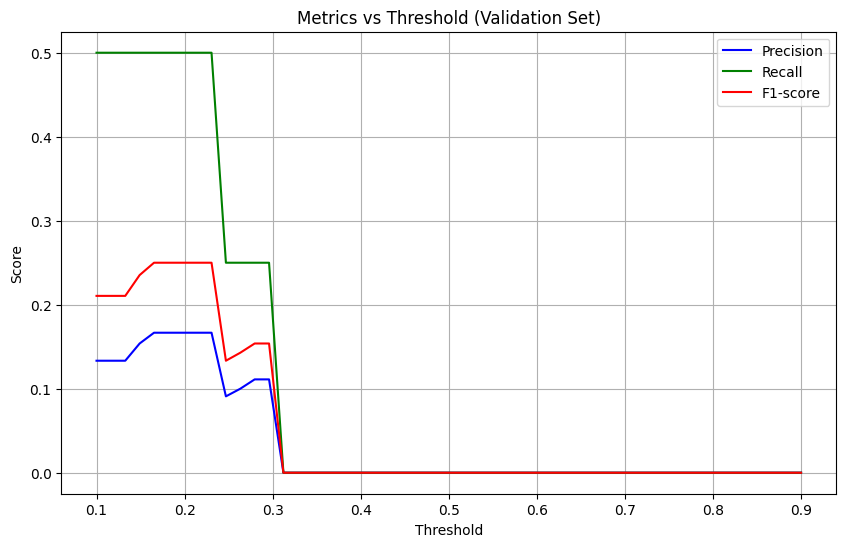

Оптимальный порог: 0.165, f-1 score: 0.25

Logistic Regression:
Accuracy: 0.600
Precision: 0.375
Recall: 0.500
ROC-AUC: 0.690


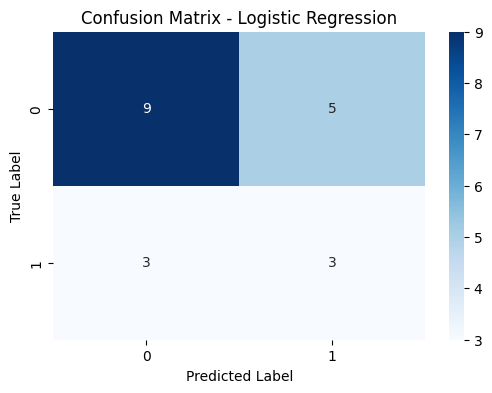

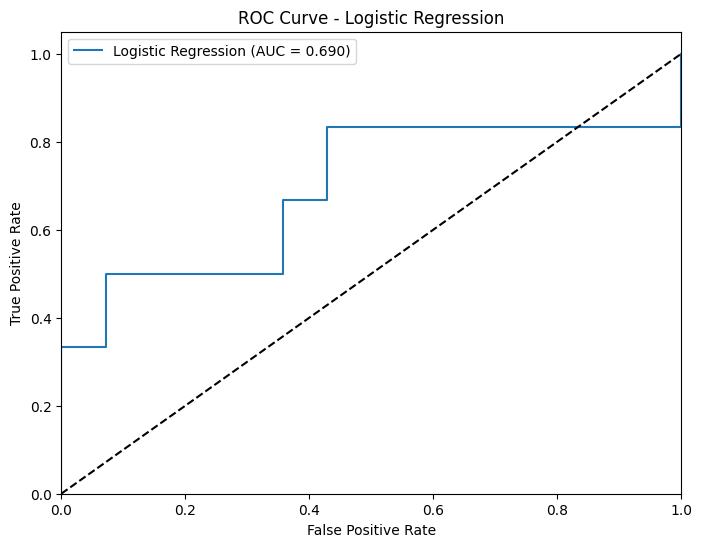

In [355]:
lr_clf = LogisticRegression(learning_rate=0.1, n_iter=1000)
lr_clf.fit(X_train_scaled, y_train)

thresholds = np.linspace(0.1, 0.9, 50)
precisions = []
recalls = []
f1_scores = []

y_proba_val = lr_clf.predict_proba(X_val_scaled)[:, 1]

for threshold in thresholds:
    y_pred_val = (y_proba_val >= threshold).astype(int)
    
    precision = precision_score(y_val, y_pred_val, zero_division=0)
    recall = recall_score(y_val, y_pred_val, zero_division=0)
    
    precisions.append(precision)
    recalls.append(recall)
    
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    f1_scores.append(f1)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, 'b-', label='Precision')
plt.plot(thresholds, recalls, 'g-', label='Recall')
plt.plot(thresholds, f1_scores, 'r-', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs Threshold (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Оптимальный порог: {best_threshold:.3f}, f-1 score: {f1_scores[np.argmax(f1_scores)]}")

results['Logistic Regression'] = evaluate_model(lr_clf, X_test_scaled, y_test, 
                                               "Logistic Regression", threshold=best_threshold)

In [356]:
summary_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [r['accuracy'] for r in results.values()],
    'Precision': [r['precision'] for r in results.values()],
    'Recall': [r['recall'] for r in results.values()],
    'ROC-AUC': [r['roc_auc'] if r['roc_auc'] is not None else 'N/A' for r in results.values()]
})

print(summary_df.to_string(index=False))

              Model  Accuracy  Precision   Recall  ROC-AUC
            Trivial      0.70   0.000000 0.000000 0.500000
        Naive Bayes      0.75   0.666667 0.333333 0.642857
                KNN      0.70   0.500000 0.333333 0.595238
Logistic Regression      0.60   0.375000 0.500000 0.690476
